In [27]:
#import dependecies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def func(x):
    if x == '<2.5':
        return 2.5
    elif x is np.NaN:
        return x
    return float(x)

In [29]:
# prepare dataset
dataframe_raw = pd.read_csv('Food_Security_Data_E_All_Data_NOFLAG.csv', encoding='latin-1').iloc[0:14136, :]
indexed_countries = pd.read_excel('indexes.xlsx')
var_df = pd.read_csv('variables_final.csv')
chosen_variables, var_codes = list(var_df.variables), list(var_df.code)
# generate desired columns, Y201X201Y, Y201X... 
# this is from 2012 to 2018
years = [f'Y{i}' for i in range(2012, 2020)]
years_avg = [f'Y{i-1}{i+1}' for i in range(2012, 2020)]
# years = ['Y2020']
# years_avg = ['Y20192021']
desired_columns = ['Area', 'Item'] + years + years_avg

# get list of countries that are viable for modelling
indexed_countries_list = list(indexed_countries.Country)

In [30]:
# categorize into dictionary of (country_name): dataframe_countries
dataframe_countries = {}
for country in sorted(dataframe_raw.Area.unique()):
    # separate countries not considered by GFIS Indexing
    if country in indexed_countries_list:
        # get dataframe with rows/columns that has row Area == country
        curr_df = dataframe_raw[dataframe_raw.Area == country].loc[:, desired_columns]
        
        # now get the columns that has 'Item' in our chosen_variables list
        for item in curr_df['Item']:
            if item in chosen_variables:
                curr_item = curr_df.loc[curr_df.Item == item, years + years_avg].T

                # add to dataframe, column by column
                if dataframe_countries.get(country) is None:
                    dataframe_countries[country] = pd.DataFrame()
                dataframe_countries[country][item] = curr_item
    
        # if it does not have all the variables in chosen_variables, delete and continue to next country
        if dataframe_countries[country].shape[1] != len(chosen_variables):
            del dataframe_countries[country]
            continue

        # now to combine rows, e.g Y20122014 into Y2013
        for (yavg, y) in zip(years_avg, years):
            curr_df = dataframe_countries[country]
            curr_df.loc[y, :] = np.where(pd.notna(curr_df.loc[y, :]), curr_df.loc[y, :], curr_df.loc[yavg, :])

        # then drop 3-year average rows, e.g Y20122014 rows
        curr_df = curr_df.drop(years_avg)

        # now to combine indexed_countries dataframe into a column of the dataframe, 'Country_Index'"new_test - Copy.ipynb"
        curr_df['Country_Index'] = indexed_countries[indexed_countries.Country == country].T.iloc[1:, :]
    
        # now to add country names just so we know which country is which
        curr_df.insert(0, 'Country', [country for i in range(len(years))])

        # replace the transformed dataframe in dictionary
        dataframe_countries[country] = curr_df

# Combine all country dataframes into one dataframe
df = pd.concat(dataframe_countries.values())
df = df.dropna(axis=0)
for column in df.columns[1:]:
    df[column] = df[column].apply(func)
df.reset_index(inplace=True)


--------------------
Coefficients:
    Average dietary energy supply adequacy (percent) (3-year average): [-0.36214577]
    Gross domestic product per capita, PPP, (constant 2017 international $): [4.27808079]
    Percentage of population using safely managed drinking water services (Percent): [3.98675029]
    Prevalence of undernourishment (percent) (3-year average): [-2.41949071]
    Political stability and absence of violence/terrorism (index): [2.43899833]
MSE: [[22.33987228]]
R_squared: [0.84437785]
adj_R_squared: [0.83957469]
--------------------

--------------------
Coefficients:
    Average dietary energy supply adequacy (percent) (3-year average): [-0.30643887]
    Gross domestic product per capita, PPP, (constant 2017 international $): [5.67915094]
    Percentage of population using safely managed drinking water services (Percent): [2.94751843]
    Prevalence of undernourishment (percent) (3-year average): [-1.86848066]
    Political stability and absence of violence/terrori

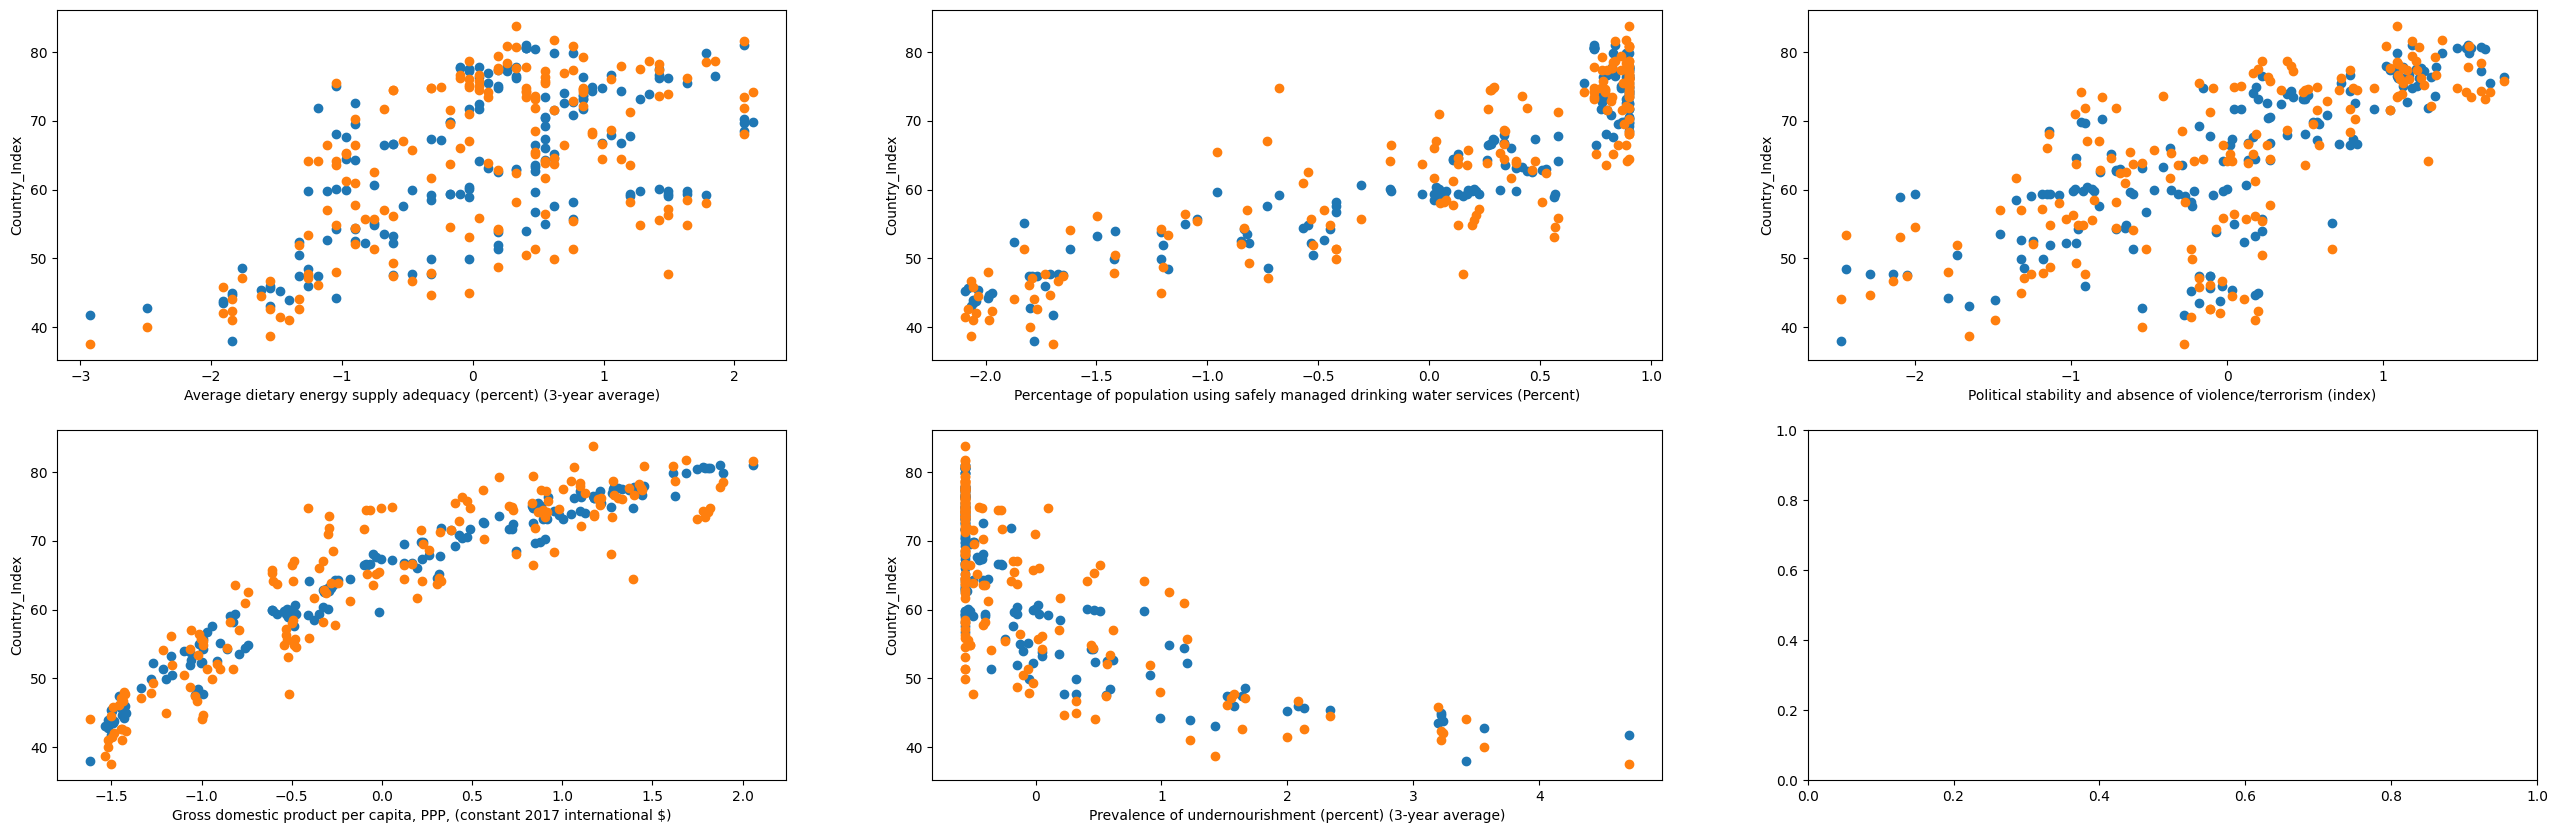

In [35]:
class MLRModel():
    def __init__(self, df, features, target):
        self.df = df
        self.features = features
        self.target = target
        self.df_features, self.df_target = self._get_features_target()
        self.train_set = None
        self.test_set = None
        self.pred = None
        self.coef_ = None
        self.J = None
        self.r2_ = None
        self.mse_ = None
        self.adj_r2_ = None
        self.mean = None
        self.std = None
    
    def _get_features_target(self):
        return pd.DataFrame(self.df.loc[:, self.features]), pd.DataFrame(self.df.loc[:, self.target])

    def normalize(self, df, norm_method):
        if norm_method == 'minmax':
            df_max = df.max(axis=0)
            df_min = df.min(axis=0)
            df = (df-df_min)/(df_max-df_min)

        
        elif norm_method == 'zscore':
            self.mean = df.mean(axis=0)
            df_mean = df.mean(axis=0)
            self.std = df.std(axis=0)
            df_std = df.std(axis=0)
            df = (df - df_mean)/df_std
        
        return df   

    @staticmethod
    def _prepare_features(df):
        df.insert(0, 'ones', 1)
        return df.to_numpy()

    @staticmethod
    def _compute_cost(X, y, beta):
        y_hat = X @ beta
        y_hat_minus_y = y_hat - y
        m = X.shape[0]
        J = 1/(2*m) * y_hat_minus_y.T @ y_hat_minus_y
        return J[0,0]

    def __str__(self):
        line = '-' * 20 + '\n'
        coefline = "Coefficients:\n"
        for coef, feature in zip(self.coef_[1:], self.features):
            coefline += f'    {feature}: {coef}\n'


        mseline = f'MSE: {self.mse_}\n'
        r2line = f'R_squared: {self.r2_[0]}\n'
        adj_r2line = f'adj_R_squared: {self.adj_r2_[0]}\n'

        return line + coefline + mseline + r2line + adj_r2line + line

    def _split(self, random_state, test_size, df_features, df_target):
        np.random.seed(random_state)
        indexes = df_features.index
        k = int(len(indexes) * test_size)
        test_index = set(np.random.choice(indexes, size=k, replace=False))
        train_index = set(indexes) - test_index
        test_index, train_index = list(test_index), list(train_index)
        df_features_train = df_features.iloc[train_index, :]
        df_features_test = df_features.iloc[test_index, :]
        df_target_train = df_target.iloc[train_index, :]
        df_target_test = df_target.iloc[test_index, :]
        
        return df_features_train, df_features_test, df_target_train, df_target_test

    def _gradient_descent(self, train_set, beta, alpha, num_iters):

        X, y = train_set
        J = []
        for i in range(num_iters):
            y_hat = X @ beta
            y_diff = y_hat - y
            m = X.shape[0]
            beta = beta - alpha * 1/m * X.T @ y_diff
            curr_J = 1/(2*m) * y_diff.T @ y_diff
            J.append(curr_J[0, 0])

        return beta, J

    def reset_feature_targets(self):
        self.df_features, self.df_target = self._get_features_target()

    def apply_func(self, chosen_features, func):
        df = self.df_features
        for feature in chosen_features:
            if feature in self.features:
                df[feature] = df[feature].apply(func)
        
    def prepare_fit(self, random_state=100, test_size=0.3, norm_method='zscore'):
        # split
        df_features_train, df_features_test, df_target_train, df_target_test = self._split(random_state, test_size, self.normalize(self.df_features, norm_method), self.df_target)

        # prepare features, assign to train_set and test_set
        self.train_set = self._prepare_features(df_features_train), df_target_train.to_numpy()
        self.test_set = self._prepare_features(df_features_test), df_target_test.to_numpy()

    def fit(self, alpha=0.01, num_iters=1500):
        # if prepare_fit has not been called
        if not self.train_set:
            raise Exception('train/test set not prepared')

        beta = np.zeros((len(self.features) + 1, 1))
        self.coef_, self.J = self._gradient_descent(self.train_set, beta, alpha, num_iters)
    
    def predict(self, test_set=None):
        if test_set:
            features, y_actual = test_set
        else:
            features, y_actual = self.test_set
            
        self.pred = features @ self.coef_
        y_mean = y_actual.mean(axis=0)
        y_diff = y_actual - self.pred
        y_actual_mean_diff = y_actual - y_mean
        SS_res = y_diff.T @ y_diff
        SS_tot = y_actual_mean_diff.T @ y_actual_mean_diff
        
        n = y_actual.shape[0]
        self.r2_ = 1 - SS_res /SS_tot
        self.mse_ = 1/n * SS_res
        self.adj_r2_ = 1 - (1 - self.r2_) * (n - 1) / (n - len(self.features) - 1)

    def display_result(self, test_set=None):
        if test_set:
            features, target = test_set
        else:
            features, target = self.test_set
     
        n = len(self.features)
        split = (2, n//2+1)
        fig, axes = plt.subplots(split[0], split[1], figsize=(32, 10))

        for (k, feature) in enumerate(self.features):
            i = k % split[0]
            j = k // split[0]

            index = (i,j) if split[1] > 1 else i
            axes[index].scatter(features[:, k+1], self.pred)
            axes[index].scatter(features[:, k+1], target)
            axes[index].set(xlabel=feature, ylabel=self.target)

model = MLRModel(df=df, features=chosen_variables, target='Country_Index')
model.prepare_fit()
model.fit()
model.predict()
print(model)

# print(model)
# model.display_result()
# test_2021 = pd.read_excel('JAMES.xlsx')
# feat, tar = pd.DataFrame(test_2021.loc[:, model.features]), pd.DataFrame(test_2021.loc[:, model.target])
# feat = model.normalize(feat, 'zscore')
# feat.insert(0, 'ones', 1)
# tar = tar.to_numpy()

# model.predict((feat, tar))
# print(model)
# model.display_result((feat, tar))
    

model.apply_func([chosen_variables[1]], lambda x: x**(1/2))
model.prepare_fit()
model.fit()
model.predict()
print(model)
model.display_result()
print(model.mean, model.std)




#explain why 5- , 1- 5 do r^2. in each 
#whoismyuser
#what goals does he/she want to achieve

# model.display_result()
model.reset_feature_targets()


        

In [32]:
# df_v = df.loc[:, chosen_variables]
# myplot = sns.pairplot(df_v.set_axis(var_codes, axis=1))

In [33]:

# model = MLRModel(df=df, features=chosen_variables, target='Country_Index')
# j_storage_storage = []
# j = 0.005
# c = 0
# for i in range(0, 500, 20):
#     if c==5:
#         print(j+i/1000)
#     model.prepare_fit()
#     model.fit(alpha=j+i/1000)
#     model.predict()
#     j_storage_storage.append(model.J)
#     c+=1


# index = 0
# minimum = 99999
# for i, j_storage in enumerate(j_storage_storage):

#     min_j = min(j_storage)
#     if min_j < minimum:
#         minimum = min_j
#         index = i

# print(index, minimum)